In [24]:
import glob

In [45]:
train_images = glob.glob('../create_dataset/dataset/images/1*.png')

In [27]:
from PIL import Image

In [28]:
sample = Image.open(train_images[0])

In [30]:
import numpy as np

In [54]:
counter = 0
id_map = {}

trains = []
labels = []

for image in train_images:
    image_id = image.split('/')[-1].split('@')[0]
    
    label = 0
    if id_map.get(image_id) is None:
        label = counter
        id_map[image_id] = counter
        counter+=1
    else:
        label = id_map[image_id]
    
    img = Image.open(image)
    img_np = np.asanyarray(img)
    flatten = img_np[:, :, :-1].flatten() / 255.
    
    trains.append(list(flatten))
    labels.append(label)

trains = np.asarray(trains)
labels = np.asarray(labels)

In [55]:
trains.shape

(2856, 7500)

In [56]:
labels.shape

(2856,)

In [65]:
trains = trains.astype('float32')

In [66]:
x_trains = trains[:2500, :]
x_tests = trains[2500:, :]

In [75]:
y_trains = labels[:2500]
y_tests = labels[2500:]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [58]:
batch_size = 100
original_dim = 7500
latent_dim = 50
intermediate_dim = 1000
epochs = 50
epsilon_std = 1.0


In [67]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


In [68]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [69]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [70]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [71]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

/Users/RyotaKatoh/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_3" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11460608/11490434 [============================>.] - ETA: 0s

In [11]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [73]:
vae.fit(x_trains,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_tests, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

Train on 2500 samples, validate on 356 samples
Epoch 1/50
2500/2500 [==============================] - 6s - loss: 3761506900.7765 - val_loss: 5389.2619
Epoch 2/50
2500/2500 [==============================] - 5s - loss: 5214.8074 - val_loss: 5614.7800
Epoch 3/50
2500/2500 [==============================] - 5s - loss: 5296.7218 - val_loss: 5367.9659
Epoch 4/50
2500/2500 [==============================] - 6s - loss: 5256.6248 - val_loss: 5648.0940
Epoch 5/50
2500/2500 [==============================] - 5s - loss: 5237.9329 - val_loss: 5380.8848
Epoch 6/50
2500/2500 [==============================] - 6s - loss: 5200.3950 - val_loss: 5387.3074
Epoch 7/50
2500/2500 [==============================] - 5s - loss: 5149.0278 - val_loss: 5941.2981
Epoch 8/50
2500/2500 [==============================] - 5s - loss: 5215.1964 - val_loss: 5434.3523
Epoch 9/50
2500/2500 [==============================] - 6s - loss: 5195.9034 - val_loss: 5919.6976
Epoch 10/50
2500/2500 [==============================] -

In [13]:
%matplotlib inline

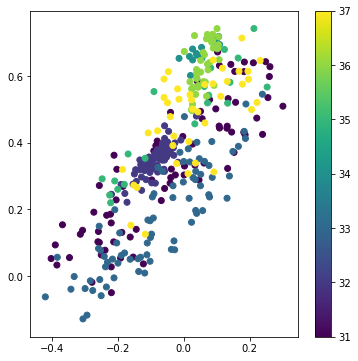

In [76]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_tests, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_tests)
plt.colorbar()
plt.show()

In [77]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [117]:
# z_sample = np.random.normal(0.0, 1.0, (50,))
z_sample = np.zeros((50,))

In [118]:
z_sample.reshape(50)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [119]:
x_decoded = generator.predict(z_sample.reshape((1, 50)))

In [120]:
decoded = Image.fromarray((x_decoded.reshape((50, 50, 3)) * 255. ).astype(np.uint8))

In [121]:
fuck = Image.fromarray((x_decoded * 255.).astype(np.uint8).reshape((50, 50, 3)))

In [122]:
fuck.save('./fuck.jpg')

In [78]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 50
figure = np.zeros((digit_size * n, digit_size * n, 3))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size, 3)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size, :] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

ValueError: Error when checking : expected input_5 to have shape (None, 50) but got array with shape (1, 2)